In [48]:
import os
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image, ImageChops, ImageEnhance

In [49]:
class ForgeryDetector:
    def __init__(self, dataset_path, image_size=(224, 224)):
        self.dataset_path = dataset_path
        self.image_size = image_size
        self.model = None
        self.history = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None

    def gaussian_blur_difference(self, image):
        """Apply Gaussian blur and compute absolute difference."""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        diff = cv2.absdiff(gray, blurred)
        return cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)

    def error_level_analysis(self, image, quality=95):
        """Perform Error Level Analysis (ELA) on an image."""
        try:
            im = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            temp_compressed = "temp_compressed.jpg"
            im.save(temp_compressed, "JPEG", quality=quality)
            compressed = Image.open(temp_compressed)
            ela_image = ImageChops.difference(im, compressed)
            ela_image = ImageEnhance.Brightness(ela_image).enhance(5)
            os.remove(temp_compressed)
            return cv2.cvtColor(np.array(ela_image), cv2.COLOR_RGB2BGR)
        except Exception as e:
            print(f"ELA Error: {e}")
            return None

    def preprocess_image(self, image):
        """Apply Gaussian Blur Difference and Error Level Analysis."""
        gb_diff = self.gaussian_blur_difference(image)
        ela_image = self.error_level_analysis(image)
        if ela_image is None:
            return None
        gb_resized = cv2.resize(gb_diff, self.image_size)
        ela_resized = cv2.resize(ela_image, self.image_size)
        return cv2.addWeighted(gb_resized, 0.1, ela_resized, 0.9, 0)

    def prepare_dataset(self, data_limit=None):
        """Load and preprocess images, returning feature matrix X and labels y."""
        X, y = [], []
        for class_name in ["Au", "Tp"]:
            class_path = os.path.join(self.dataset_path, class_name)
            label = 0 if class_name == "Au" else 1
            data_list = (
                os.listdir(class_path)[0:data_limit]
                if data_limit
                else os.listdir(class_path)
            )
            for img_file in data_list:
                if img_file.lower().endswith(
                    (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
                ):
                    img = cv2.imread(os.path.join(class_path, img_file))
                    processed_img = self.preprocess_image(img)
                    if processed_img is not None:
                        X.append(processed_img)
                        y.append(label)
        return np.array(X), np.array(y)

    def build_model(self):
        """Build and compile a MobileNetV2-based model."""
        input_tensor = Input(shape=(self.image_size[0], self.image_size[1], 3))
        base_model = MobileNetV2(
            weights="imagenet", include_top=False, input_tensor=input_tensor
        )
        for layer in base_model.layers[:-5]:
                layer.trainable = False
        for layer in base_model.layers[-5:]:
            layer.trainable = True


        # base_model.trainable = False
        x = Flatten()(base_model.output)
        x = Dense(1024, activation="relu")(x)
        x = Dropout(0.6)(x)
        x = Dense(512, activation="relu")(x)
        x = Dropout(0.6)(x)
        output = Dense(1, activation="sigmoid")(x)
        self.model = Model(inputs=base_model.input, outputs=output)
        self.model.compile(
            optimizer=Adam(learning_rate=1e-5),
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"],
        )
        return self.model

    def train_model(self, X, y, epoch=50):
        """Train the model with optimized parameters and class weighting."""
        X = preprocess_input(X)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X_train,
            self.y_train,
            test_size=0.25,
            stratify=self.y_train,
            random_state=42,
        )

        early_stopping = EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )
        lr_scheduler = ReduceLROnPlateau(
            monitor="val_loss", factor=0.2, patience=5, min_lr=1e-7
        )

        self.history = self.model.fit(
            self.X_train,
            self.y_train,
            validation_data=(self.X_val, self.y_val),
            epochs=epoch,
            batch_size=42,
            callbacks=[early_stopping, lr_scheduler],
        )
        self.model.summary()

    def evaluate_model(self):
        """Evaluate the model on the test set and generate various plots."""
        test_loss, test_accuracy, test_auc = self.model.evaluate(
            self.X_test, self.y_test, verbose=1
        )
        y_pred_proba = self.model.predict(self.X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()

        print("\nTest Metrics:")
        print(classification_report(self.y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Non-Forged", "Forged"],
            yticklabels=["Non-Forged", "Forged"],
        )
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        # plt.savefig('confusion_matrix.png')
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {test_auc:.2f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        # plt.savefig('roc_curve.png')
        plt.show()

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(self.y_test, y_pred_proba)
        plt.figure()
        plt.plot(recall, precision, label="Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
        # plt.savefig('precision_recall_curve.png')
        plt.show()

    def plot_training_curves(self):
        """Plot training history including loss, accuracy, and AUC on a 0-100% scale."""
        print(self.history.history.keys())

        fig, ax = plt.subplots(3, 1, figsize=(8, 12))  # 3 rows, 1 column, taller figure

        # Accuracy (Scaled to 0-100%)
        ax[0].plot(np.array(self.history.history['accuracy']) * 100, label='Train Accuracy')
        ax[0].plot(np.array(self.history.history['val_accuracy']) * 100, label='Val Accuracy')
        ax[0].set_title('Accuracy')
        ax[0].set_ylabel('Accuracy (%)')
        ax[0].set_xlabel('Epoch')
        ax[0].legend()
        # ax[0].grid(True)

        # Loss (Keep original scale)
        ax[1].plot(self.history.history['loss'] , label='Train Loss')
        ax[1].plot(self.history.history['val_loss'], label='Val Loss')
        ax[1].set_title('Loss')
        ax[1].set_ylabel('Loss')
        ax[1].set_xlabel('Epoch')
        ax[1].legend()
        # ax[1].grid(True)

        # AUC (Scaled to 0-100%)
        ax[2].plot(np.array(self.history.history['AUC']) * 100, label='Train AUC')
        ax[2].plot(np.array(self.history.history['val_AUC']) * 100, label='Val AUC')
        ax[2].set_title('AUC Score')
        ax[2].set_ylabel('AUC (%)')
        ax[2].set_xlabel('Epoch')
        ax[2].legend()
        # ax[2].grid(True)

        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()


In [50]:
dataset_path = r"./CASIA22"
detector = ForgeryDetector(dataset_path)

# 1. Prepare the dataset:
data_limit = None
X, y = detector.prepare_dataset(data_limit=data_limit)
print(X.shape, y.shape)


(12614, 224, 224, 3) (12614,)


In [51]:
detector.build_model()


/var/folders/rz/1_0vymm50cxb84f_6l23t6j80000gn/T/ipykernel_1138/860842798.py:71: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


<Functional name=functional_7, built=True>

In [52]:
epoch = 100
detector.train_model(X, y, epoch)

Epoch 1/100


/Users/logpoint/Documents/SoftwareProjects/Thesis/venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1120']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


181/181 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - AUC: 0.8077 - accuracy: 0.7566 - loss: 0.7304 - val_AUC: 0.9249 - val_accuracy: 0.8522 - val_loss: 0.3484 - learning_rate: 1.0000e-05
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - AUC: 0.9084 - accuracy: 0.8411 - loss: 0.4286 - val_AUC: 0.9308 - val_accuracy: 0.8593 - val_loss: 0.3320 - learning_rate: 1.0000e-05
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - AUC: 0.9286 - accuracy: 0.8592 - loss: 0.3589 - val_AUC: 0.9346 - val_accuracy: 0.8744 - val_loss: 0.3193 - learning_rate: 1.0000e-05
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - AUC: 0.9439 - accuracy: 0.8795 - loss: 0.3111 - val_AUC: 0.9386 - val_accuracy: 0.8740 - val_loss: 0.3118 - learning_rate: 1.0000e-05
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - AUC: 0.9559 - accuracy: 0.8911 - loss: 0.2691 - val_AUC: 0.9393 - val_accuracy: 0.8763 - val_loss: 0.3128 - learning_rate: 1.0000e-05
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - AUC: 0

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 197,952,837 (755.13 MB)

 Trainable params: 65,471,617 (249.75 MB)

 Non-trainable params: 1,537,984 (5.87 MB)

 Optimizer params: 130,943,236 (499.51 MB)

dict_keys(['AUC', 'accuracy', 'loss', 'val_AUC', 'val_accuracy', 'val_loss', 'learning_rate'])


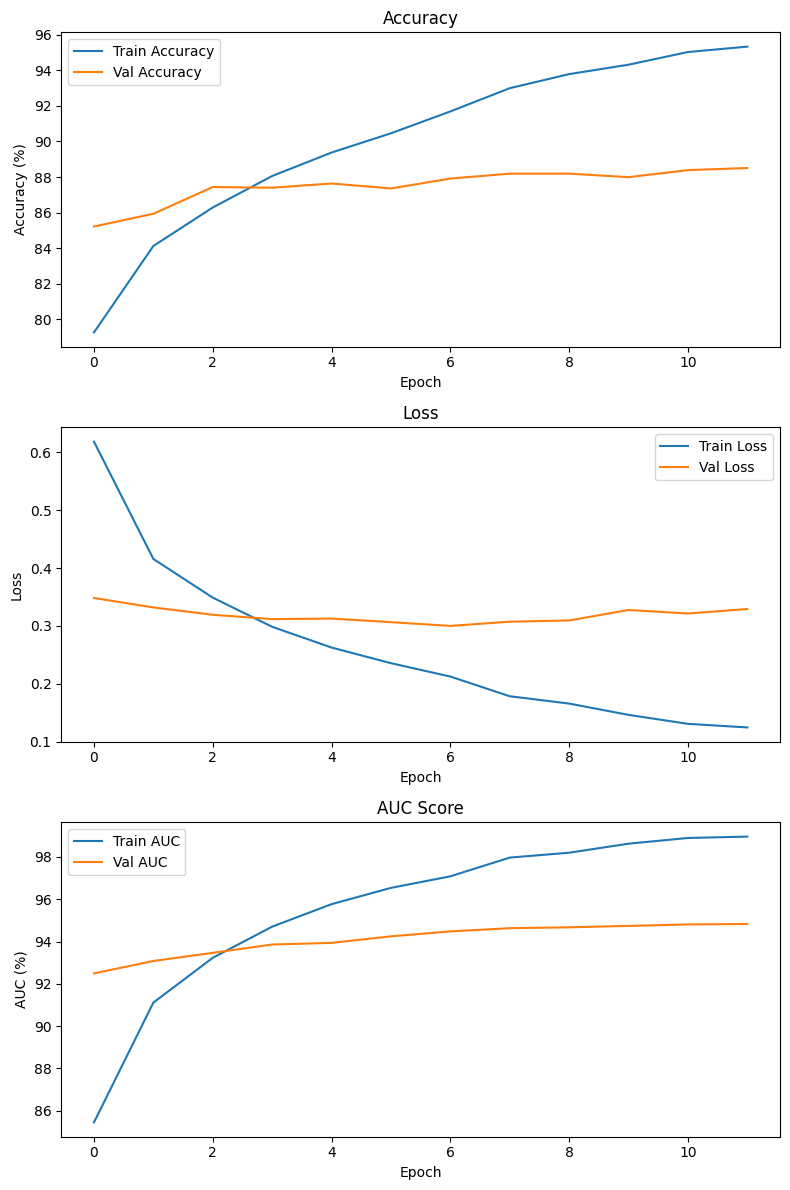

In [53]:
detector.plot_training_curves()

79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 460ms/step - AUC: 0.9422 - accuracy: 0.8662 - loss: 0.3005


/Users/logpoint/Documents/SoftwareProjects/Thesis/venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1120']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 468ms/step

Test Metrics:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1498
           1       0.83      0.86      0.85      1025

    accuracy                           0.87      2523
   macro avg       0.87      0.87      0.87      2523
weighted avg       0.87      0.87      0.87      2523



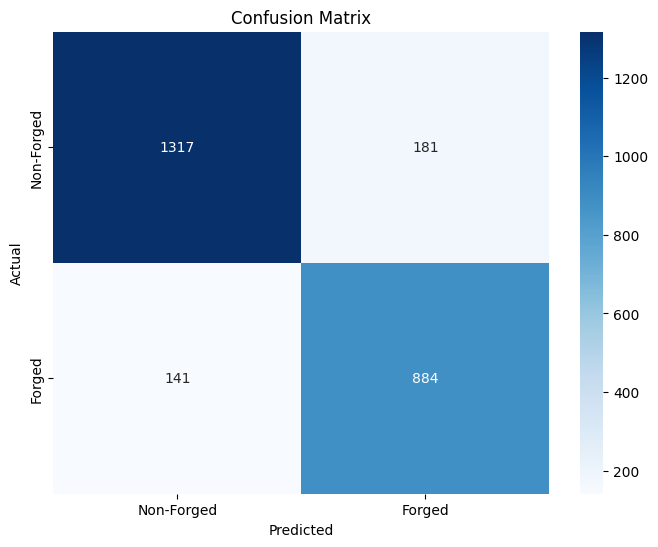

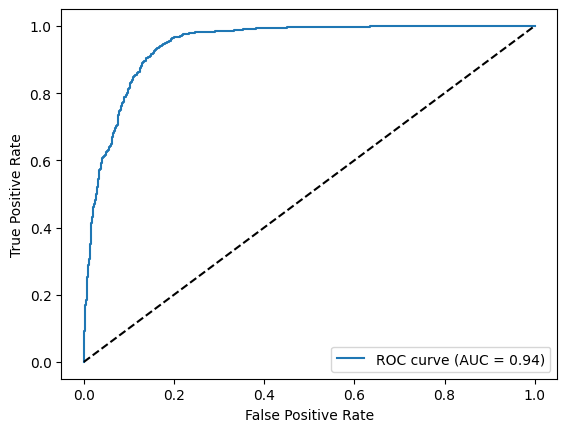

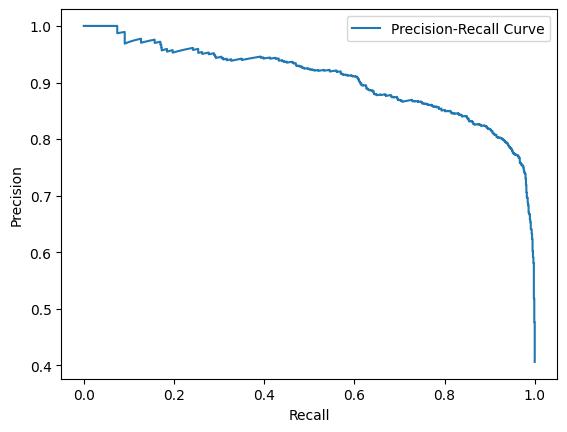


Test Metrics: None


In [54]:
# 5. Evaluate the model on the TEST set:
test_metrics = detector.evaluate_model()
print("\nTest Metrics:", test_metrics)